The purpose of these experiments is to **think about a property of initialization that end up in small error after training**.

For different initializations of $w$, record: 
- average number of matches for each state 
- loss before gradient descent
- loss after gradient descent

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,seaborn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

gpu_id = 0

%matplotlib inline

In [2]:
# Architectures. 
# Input will be a dictionary of required arguments (dimensions of certain tensors)
# Output will be a dictionary of access to graph tensors

# Standard 3-layer mlp
def mlp(input_dict):
    p = input_dict['p']
    h = input_dict['h']
    mlp_in = tf.placeholder(tf.float32, shape=[None, p])
    weights1 = tf.get_variable('w1',initializer=tf.random_normal(shape=[p,h],
                                                                 stddev=1./np.sqrt(p)))
    mlp_hidden = tf.nn.relu(tf.matmul(mlp_in, weights1), name='mlp_hidden')
    weights2 = tf.get_variable('w2',initializer=tf.random_normal(shape=[h,1],
                                                                 stddev=1./np.sqrt(h)))
    mlp_out = tf.nn.relu(tf.matmul(mlp_hidden, weights2), name='mlp_output')
    return dict(x=mlp_in,yhat=mlp_out,hid=mlp_hidden,weights1=weights1,weights2=weights2)

In [74]:
def loss(y,yhat):
    return tf.reduce_mean(tf.squared_difference(y,yhat), name='mse')

def w_gap(w,what):
    return tf.reduce_sum([tf.reduce_sum(tf.squared_difference(w[k],what[k])) for k in w])

def graph_builder_wrapper(input_dict,build_func=mlp,lr_initial=0.01,max_save=100):
    y = tf.placeholder(tf.float32, shape=[None,1])
    graph = build_func(input_dict)
    
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    
    total_loss = loss(y, graph['yhat'])
    total_w_gap = w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    opt_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)
    graph['y'] = y
    graph['w'] = w
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    return graph

# Generate random labels with underlying true weights
def generate_random_weights_and_output(X,input_dict,build_func=mlp,batch_size=100,seed=0):    
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    graph = build_func(input_dict)
    y = np.zeros((len(X),1))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        w = {k:sess.run(graph[k]) for k in graph if 'weights' in k} # grab all weights for graph
        for i in range(0,len(X),batch_size):
            y_ = sess.run(graph['yhat'],feed_dict={graph['x']: X[i:i+batch_size]})
            y[i:i+batch_size] = y_
    return y,w

# Generate random labels with underlying true weights
def generate_output(X,w,build_func=mlp,batch_size=100):    
    tf.reset_default_graph()
    graph = build_func(input_dict)
    y = np.zeros((len(X),1))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(0,len(X),batch_size):
            feed_dict = {graph[k]:w[k] for k in w}
            feed_dict[graph['x']] = X[i:i+batch_size]
            y_ = sess.run(graph['yhat'],feed_dict=feed_dict)
            y[i:i+batch_size] = y_
    return y

def compute_wgap_and_loss(X,Y,w_true,graph,sess,batch_size=100):
    l = []
    for i in range(0,len(X),batch_size):
        x,y = X[i:i+batch_size], Y[i:i+batch_size]
        l.append(sess.run(graph['total_loss'],feed_dict={graph['x']:x,graph['y']:y}))
    wg = sess.run(graph['total_w_gap'],feed_dict={graph['w'][k]:w_true[k] for k in w_true})
    return wg, np.mean(l)

# Training
# w_initial should be a dictionary with keys corresponding to weight matrices in the graph
def train(X,Y,graph,num_epochs,batch_size,w_true,w_initial=None):

    start = time.time()
    training_losses = []
    training_w_gaps = []
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        if w_initial is not None: 
            for k in w_initial: sess.run(graph[k].assign(w_initial[k]))
                
        # Compute initial w gap and loss
        initial_train_w_gap,initial_train_loss = compute_wgap_and_loss(X,Y,w_true,graph,sess,
                                                                       batch_size=batch_size)
        
        for epoch in range(num_epochs):
            lr = 0.01*0.95**(epoch/390.) # initial lr * decay rate ^(step/decay_steps)
            sess.run(graph['learning_rate'].assign(lr))
            t = time.time()
            training_loss = 0
            training_w_gap = 0
            steps = 0.
            X_, Y_ = shuffle(X,Y)
            for i in range(0,len(X),batch_size):
                x,y = X_[i:i+batch_size], Y_[i:i+batch_size]
                feed_dict = {graph['w'][k]:w_true[k] for k in w_true}
                feed_dict[graph['x']] = x
                feed_dict[graph['y']] = y
                training_loss_,training_w_gap_,_ = sess.run([graph['total_loss'],
                                                             graph['total_w_gap'],
                                                             graph['opt_step']],
                                                            feed_dict=feed_dict)
                training_loss += training_loss_
                training_w_gap += training_w_gap_
                steps += 1.
                
                print('\rEpoch %s/%s (%.3f s), batch %s/%s (%.3f s): loss %.3f, w gap: %.3f'
                      %(epoch+1,num_epochs,time.time()-start,steps,
                        len(X_)/batch_size,time.time()-t,
                        training_loss_,training_w_gap_),end='')
            training_losses.append(training_loss/steps)
            training_w_gaps.append(training_w_gap/steps)

        w_hat = {k:sess.run(graph[k]) for k in graph if 'weights' in k} # grab all final weights
        final_w_gap,final_train_loss = compute_wgap_and_loss(X,Y,w_true,graph,sess,
                                                             batch_size=batch_size)
    
    print('')
    return training_losses,training_w_gaps,w_hat, \
           initial_train_loss,initial_train_w_gap,final_train_loss,final_w_gap

# Get hidden node states (either on or off) using given weights
# weights is a dictionary with keys corresponding to weight matrices in the graph
def get_hidden_states(X,input_dict,weights,build_func=mlp,batch_size=100):
    tf.reset_default_graph()
    graph = build_func(input_dict)
    states = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(0,len(X),batch_size):
            feed_dict = {graph[k]:weights[k] for k in weights}
            feed_dict[graph['x']] = X[i:i+batch_size]
            if 'hid' in graph: hout_ = sess.run(graph['hid'],feed_dict=feed_dict)
            else: hout_ = sess.run(graph['yhat'],feed_dict=feed_dict)
            states.append(hout_)
    return np.vstack(states) > 0

def get_loss(X,Y,w,build_func=mlp):
    tf.reset_default_graph()
    graph = graph_builder_wrapper(input_dict,build_func=build_func)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for k in w: sess.run(graph[k].assign(w[k]))
        feed_dict = {graph['x']: X, graph['y']: Y}
        return sess.run(graph['total_loss'],feed_dict=feed_dict)

In [71]:
# Functions for generating data
def generate_X(N,q,input_dict):
    # generate covariance matrix approach 1: all iid
    # C = np.eye(p)
    # A = np.eye(p)
    # generate covariance matrix approach 2: low-rank covariance matrix
    p = input_dict['p']
    A = np.random.normal(0,1,[p,q])
    C = np.dot(A,A.T)
    u,s,v = np.linalg.svd(C)
    C /= np.sum(s[:q])/p               # Scale C to ensure eigenvalues sum up to p
    u,v = np.linalg.eigh(C)
    u[u < 0] = 0
    A = np.dot(v,np.diag(np.sqrt(u)))
    B = np.random.normal(0,1,(10,10))  # Rotate A by random matrix to ensure samples are dense
    u,v = np.linalg.eigh(C)
    A = np.dot(A,v)
    X = np.dot(np.random.normal(0,1,[N,p]),A.T) # sample X
    return X

def generate_data(N,q,input_dict,seed=0,build_func=mlp):
    np.random.seed(seed)
    X = generate_X(N,q,input_dict)
    Y,weights = generate_random_weights_and_output(X,input_dict,build_func=build_func)
    hs = get_hidden_states(X,input_dict,weights,build_func=build_func)
    return X,Y,hs,weights

In [59]:
def run_experiment(X,Y,hs_true,w_true,input_dict,num_sims,build_func=mlp,plot=False,init_perturb_w_true=None):
    
    if 'h' in input_dict: h = input_dict['h']
    else: h = 1
    p = input_dict['p']
    
    all_prop_matched_states = np.zeros((num_sims,h))
    all_final_loss = np.zeros(num_sims)
    all_final_w_gaps = np.zeros(num_sims)
    all_initial_w_gaps = np.zeros(num_sims)
    
    start = time.time()
    
    for t in range(num_sims):

        # Generate w
        if init_perturb_w_true is None:
            weights = {k:np.random.normal(0,1./np.sqrt(np.shape(w_true[k])[0]),
                                          np.shape(w_true[k])) for k in w_true}
        else:
            weights = {k:w_true[k]+np.random.normal(0,(1./np.sqrt(np.shape(w_true[k])[0]))/init_perturb_w_true,
                                          np.shape(w_true[k])) for k in w_true}
            
        # Get number of matching states for hidden layer
        hs_ = get_hidden_states(X,input_dict,weights,build_func=build_func)
        all_prop_matched_states[t] = np.mean(hs_ == hs,0)

        # Compute loss after gradient descent
        tf.reset_default_graph()
        graph = graph_builder_wrapper(input_dict,build_func=build_func)
        training_losses,training_w_gaps,w_hat,initial_train_loss,initial_train_w_gap,final_train_loss,final_w_gap = \
                train(X,Y,graph,200,100,w,w_initial=weights)
        all_final_loss[t] = final_train_loss
        all_final_w_gaps[t] = final_w_gap
        all_initial_w_gaps[t] = initial_train_w_gap

        if plot:
            plt.figure(figsize=(10,5))
            plt.subplot(121)
            plt.plot(training_w_gaps)
            plt.xlabel('epochs')
            plt.ylabel('w gap')
            plt.subplot(122)
            plt.plot(training_losses)
            plt.xlabel('epochs')
            plt.ylabel('training loss')

        print('Done with %s/%s (%.2f s elapsed)'%(t+1,num_sims,time.time()-start))
        
    return all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps

def generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps):
    f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,10))
    seaborn.regplot(np.mean(all_prop_matched_states,1),all_final_loss,ax=ax1)
    ax1.set(xlabel='proportion of matched states', ylabel='final loss')
    seaborn.regplot(all_initial_w_gaps,all_final_loss,ax=ax2)
    ax2.set(xlabel='initial w gap', ylabel='final loss')
    seaborn.regplot(all_initial_w_gaps,all_final_w_gaps,ax=ax3)
    ax3.set(xlabel='initial w gap', ylabel='final w gap')
    seaborn.regplot(np.mean(all_prop_matched_states,1),all_final_w_gaps,ax=ax4)
    ax4.set(xlabel='proportion of matched states', ylabel='final w gap')
    seaborn.regplot(all_initial_w_gaps,np.mean(all_prop_matched_states,1),ax=ax5)
    ax5.set(xlabel='initial w gap', ylabel='proportion of matched states')
    seaborn.regplot(all_final_w_gaps,all_final_loss,ax=ax6)
    ax6.set(xlabel='final w gap', ylabel='final loss')
    c = (np.max(all_final_loss)-np.min(all_final_loss))*0.1
    ax6.set_ylim(np.min(all_final_loss)-c,np.max(all_final_loss)+c)
    c = (np.max(all_final_w_gaps)-np.min(all_final_w_gaps))*0.1
    ax6.set_xlim(np.min(all_final_w_gaps)-c,np.max(all_final_w_gaps)+c)

### Experiment 1

3-layer MLP, test for low-rank and full-rank matrices.

In [6]:
# Parameters
p = 10    # number of dimensions
N = 1000  # number of samples
q = 4     # rank of covariance matrix for generating samples
h = 3     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp)

all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
    run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp,plot=False)

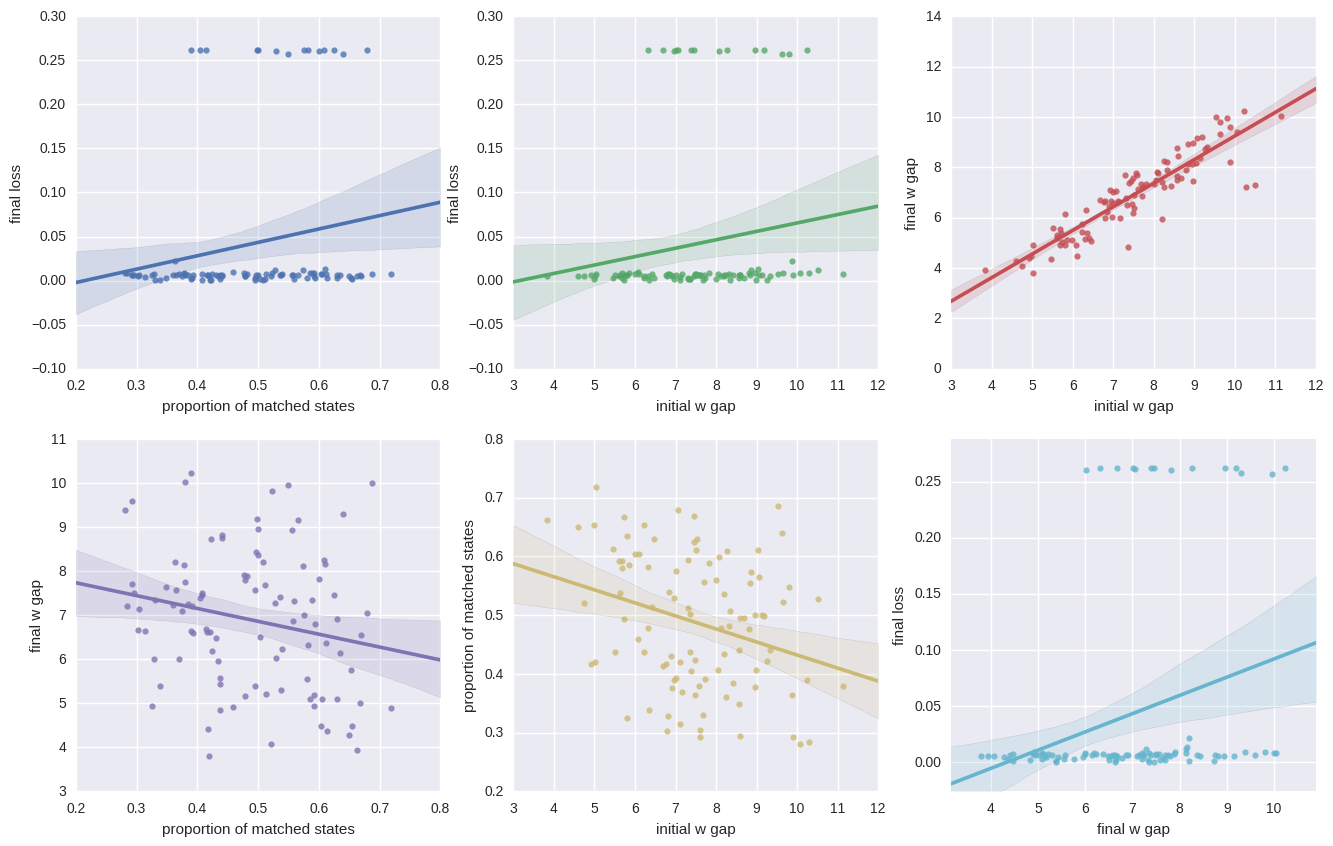

In [23]:
generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

In [24]:
# Repeat with full rank matrix

p = 10    # number of dimensions
N = 1000  # number of samples
q = p     # rank of covariance matrix for generating samples
h = 3     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp)

all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
    run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp,plot=False)

Epoch 18/200 (0.222 s), batch 9.0/10 (0.006 s): loss 0.047, w gap: 4.371

Epoch 36/200 (0.424 s), batch 3.0/10 (0.002 s): loss 0.029, w gap: 4.402

Epoch 52/200 (0.622 s), batch 10.0/10 (0.010 s): loss 0.022, w gap: 4.371

Epoch 68/200 (0.826 s), batch 10.0/10 (0.009 s): loss 0.019, w gap: 4.326

Epoch 83/200 (1.029 s), batch 10.0/10 (0.008 s): loss 0.011, w gap: 4.292

Epoch 98/200 (1.235 s), batch 10.0/10 (0.011 s): loss 0.007, w gap: 4.266

Epoch 113/200 (1.436 s), batch 10.0/10 (0.007 s): loss 0.007, w gap: 4.243

Epoch 127/200 (1.643 s), batch 10.0/10 (0.008 s): loss 0.007, w gap: 4.228

Epoch 141/200 (1.849 s), batch 6.0/10 (0.005 s): loss 0.005, w gap: 4.217

Epoch 154/200 (2.050 s), batch 4.0/10 (0.003 s): loss 0.005, w gap: 4.209

Epoch 167/200 (2.247 s), batch 10.0/10 (0.007 s): loss 0.004, w gap: 4.203

Epoch 179/200 (2.430 s), batch 10.0/10 (0.007 s): loss 0.004, w gap: 4.200

Epoch 191/200 (2.706 s), batch 10.0/10 (0.008 s): loss 0.004, w gap: 4.198

Epoch 200/200 (2.864 s), batch 10.0/10 (0.008 s): loss 0.003, w gap: 4.196
Done with 1/100 (2.92 s elapsed)
Epoch 200/200 (2.793 s), batch 10.0/10 (0.009 s): loss 0.004, w gap: 3.751
Done with 2/100 (5.78 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.007 s): loss 0.172, w gap: 9.187
Done with 3/100 (8.67 s elapsed)
Epoch 200/200 (2.819 s), batch 10.0/10 (0.010 s): loss 0.014, w gap: 6.202
Done with 4/100 (11.55 s elapsed)
Epoch 200/200 (2.988 s), batch 10.0/10 (0.007 s): loss 0.063, w gap: 3.829
Done with 5/100 (14.60 s elapsed)
Epoch 200/200 (2.804 s), batch 10.0/10 (0.008 s): loss 0.011, w gap: 8.408
Done with 6/100 (17.47 s elapsed)
Epoch 200/200 (2.793 s), batch 10.0/10 (0.008 s): loss 0.049, w gap: 7.830
Done with 7/100 (20.33 s elapsed)
Epoch 200/200 (2.959 s), batch 10.0/10 (0.007 s): loss 0.071, w gap: 9.4685
Done with 8/100 (23.35 s elapsed)
Epoch 200/200 (2.778 s), batch 10.0/10 (0.007 s): loss 0.012, w gap: 6.434
Done with 9/100 (26.20 s elapsed)
Epoch 200/200 (2.799 

Epoch 14/200 (0.248 s), batch 6.0/10 (0.007 s): loss 0.180, w gap: 7.393

Epoch 29/200 (0.449 s), batch 10.0/10 (0.009 s): loss 0.137, w gap: 7.393

Epoch 45/200 (0.654 s), batch 3.0/10 (0.003 s): loss 0.141, w gap: 7.393

Epoch 60/200 (0.855 s), batch 6.0/10 (0.007 s): loss 0.125, w gap: 7.393

Epoch 74/200 (1.053 s), batch 10.0/10 (0.010 s): loss 0.157, w gap: 7.393

Epoch 88/200 (1.254 s), batch 10.0/10 (0.009 s): loss 0.160, w gap: 7.393

Epoch 102/200 (1.454 s), batch 10.0/10 (0.008 s): loss 0.157, w gap: 7.393

Epoch 116/200 (1.661 s), batch 6.0/10 (0.006 s): loss 0.181, w gap: 7.393

Epoch 130/200 (1.862 s), batch 1.0/10 (0.002 s): loss 0.152, w gap: 7.393

Epoch 143/200 (2.063 s), batch 7.0/10 (0.007 s): loss 0.124, w gap: 7.393

Epoch 156/200 (2.261 s), batch 10.0/10 (0.010 s): loss 0.143, w gap: 7.393

Epoch 170/200 (2.469 s), batch 4.0/10 (0.003 s): loss 0.145, w gap: 7.393

Epoch 182/200 (2.663 s), batch 10.0/10 (0.011 s): loss 0.148, w gap: 7.393

Epoch 195/200 (2.865 s), batch 10.0/10 (0.007 s): loss 0.135, w gap: 7.393

Epoch 200/200 (2.948 s), batch 10.0/10 (0.007 s): loss 0.124, w gap: 7.393
Done with 75/100 (218.48 s elapsed)
Epoch 200/200 (2.806 s), batch 10.0/10 (0.007 s): loss 0.034, w gap: 7.508
Done with 76/100 (221.35 s elapsed)
Epoch 200/200 (2.838 s), batch 10.0/10 (0.008 s): loss 0.030, w gap: 7.008
Done with 77/100 (224.25 s elapsed)
Epoch 200/200 (2.967 s), batch 10.0/10 (0.010 s): loss 0.074, w gap: 7.179
Done with 78/100 (227.28 s elapsed)
Epoch 200/200 (2.804 s), batch 10.0/10 (0.008 s): loss 0.045, w gap: 8.145
Done with 79/100 (230.15 s elapsed)
Epoch 200/200 (2.783 s), batch 10.0/10 (0.010 s): loss 0.036, w gap: 4.030
Done with 80/100 (233.00 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.007 s): loss 0.046, w gap: 8.087
Done with 81/100 (235.89 s elapsed)
Epoch 200/200 (2.987 s), batch 10.0/10 (0.011 s): loss 0.014, w gap: 7.218
Done with 82/100 (238.94 s elapsed)
Epoch 200/200 (2.777 s), batch 10.0/10 (0.008 s): loss 0.011, w gap: 7.146
Done with 83/100 (241.78 s elapsed)
E

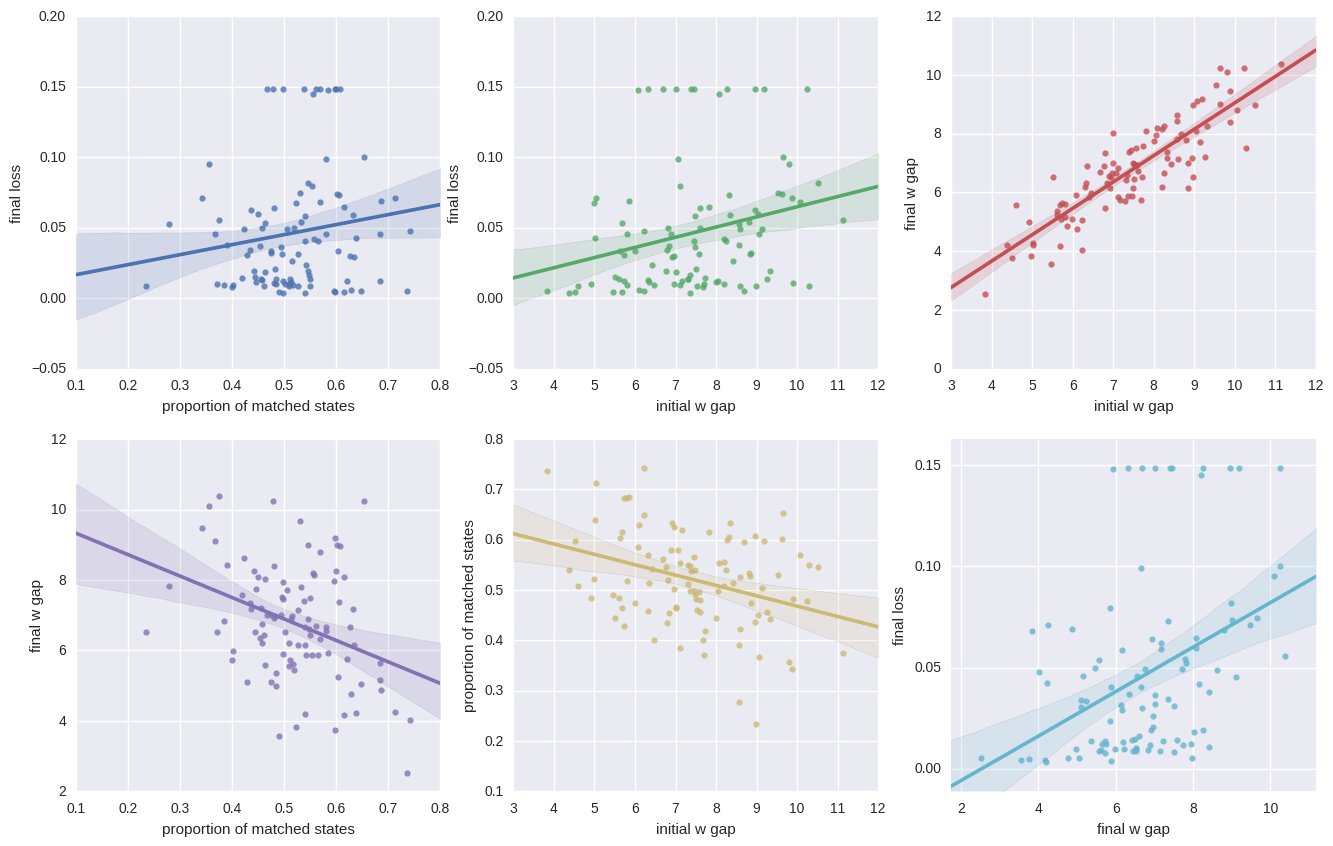

In [25]:
generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

### Experiment 2

Simply MLP with one neuron and two inputs. I.e., $y=\sigma (w_1 x_1+w_2 x_2)$.

Test for low dimension (2) and high dimension (10) cases, both with full rank matrices.

In [46]:
def mlp_simple(input_dict):
    # 2-layer net. out = relu(<weights,mlp_in>)
    p = input_dict['p']
    mlp_in = tf.placeholder(tf.float32, shape=[None, p])
    weights = tf.get_variable('w',initializer=tf.random_normal(shape=[p,1],
                                                               stddev=1./np.sqrt(p)))
    mlp_out = tf.nn.relu(tf.matmul(mlp_in, weights), name='mlp_out')
    return dict(x=mlp_in,yhat=mlp_out,weights=weights)

# Generate 3D plot of loss function (for mlp simple)
def compute_L(all_wi,all_wj):
    n = len(all_wi)
    L = np.zeros((n,n))
    start = time.time()
    for i,wi in enumerate(all_wi):
        for j,wj in enumerate(all_wj):
            tf.reset_default_graph()
            graph = graph_builder_wrapper(p,h,build_func=mlp_simple)
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                sess.run(graph['w1'].assign(np.array([[wi],[wj]])))
                feed_dict = {graph['x']: X, graph['y']: Y,
                             graph['w']: w1}
                L[i,j] = sess.run(graph['total_loss'],feed_dict=feed_dict)

            print('\r%s/%s, %s/%s (%.2f s elapsed)'%(i+1,n,j+1,n,time.time()-start),end='')
    return L

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def plot_L_3D(all_wi,all_wj,L,w1_opt,w2_opt,L_opt):
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca(projection='3d')

    wi,wj = np.meshgrid(all_wi,all_wj)
    surf = ax.plot_surface(wi, wj, L, cmap=cm.coolwarm,
                                rstride=10, cstride=10)
    ax.scatter(w1_opt,w2_opt,L_opt,c='r')
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('loss')
    plt.show()

In [42]:
# Parameters
p = 2    # number of dimensions
N = 1000  # number of samples
q = 2     # rank of covariance matrix for generating samples
h = 1     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp_simple)
print(get_loss(X,Y,w,build_func=mlp_simple)) # Check to make sure optimal loss is 0

all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
    run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp_simple,plot=False)

Epoch 20/200 (0.215 s), batch 4.0/10 (0.003 s): loss 0.008, w gap: 0.061

Epoch 38/200 (0.413 s), batch 10.0/10 (0.007 s): loss 0.002, w gap: 0.016

Epoch 56/200 (0.613 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.005

Epoch 73/200 (0.815 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.001

Epoch 90/200 (1.018 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 107/200 (1.222 s), batch 2.0/10 (0.002 s): loss 0.000, w gap: 0.000

Epoch 122/200 (1.421 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 138/200 (1.627 s), batch 6.0/10 (0.006 s): loss 0.000, w gap: 0.000

Epoch 152/200 (1.828 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 166/200 (2.034 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 180/200 (2.238 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.000

Epoch 194/200 (2.445 s), batch 6.0/10 (0.007 s): loss 0.000, w gap: 0.000

Epoch 200/200 (2.545 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.000
Done with 1/100 (2.60 s elapsed)
Epoch 200/200 (2.630 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 2/100 (5.27 s elapsed)
Epoch 200/200 (2.750 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 3/100 (8.07 s elapsed)
Epoch 200/200 (2.607 s), batch 10.0/10 (0.006 s): loss 0.000, w gap: 0.000
Done with 4/100 (10.73 s elapsed)
Epoch 200/200 (2.641 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000
Done with 5/100 (13.42 s elapsed)
Epoch 200/200 (2.682 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.000
Done with 6/100 (16.15 s elapsed)
Epoch 200/200 (2.743 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000
Done with 7/100 (18.95 s elapsed)
Epoch 200/200 (2.646 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 8/100 (21.64 s elapsed)
Epoch 200/200 (2.691 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000
Done with 9/100 (24.38 s elapsed)
Epoch 200/200 (2.750 s

Epoch 20/200 (0.236 s), batch 8.0/10 (0.005 s): loss 0.049, w gap: 0.075

Epoch 38/200 (0.437 s), batch 7.0/10 (0.006 s): loss 0.001, w gap: 0.006

Epoch 55/200 (0.638 s), batch 6.0/10 (0.004 s): loss 0.000, w gap: 0.002

Epoch 71/200 (0.836 s), batch 10.0/10 (0.006 s): loss 0.000, w gap: 0.001

Epoch 87/200 (1.039 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 102/200 (1.244 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000

Epoch 118/200 (1.449 s), batch 5.0/10 (0.003 s): loss 0.000, w gap: 0.000

Epoch 132/200 (1.651 s), batch 3.0/10 (0.003 s): loss 0.000, w gap: 0.000

Epoch 146/200 (1.853 s), batch 4.0/10 (0.004 s): loss 0.000, w gap: 0.000

Epoch 159/200 (2.050 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000

Epoch 173/200 (2.259 s), batch 4.0/10 (0.004 s): loss 0.000, w gap: 0.000

Epoch 186/200 (2.460 s), batch 7.0/10 (0.006 s): loss 0.000, w gap: 0.000

Epoch 199/200 (2.659 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.000

Epoch 200/200 (2.673 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.000
Done with 75/100 (205.34 s elapsed)


Epoch 30/200 (0.343 s), batch 10.0/10 (0.007 s): loss 0.017, w gap: 0.089

Epoch 47/200 (0.547 s), batch 9.0/10 (0.008 s): loss 0.005, w gap: 0.028

Epoch 63/200 (0.743 s), batch 10.0/10 (0.008 s): loss 0.002, w gap: 0.009

Epoch 79/200 (0.946 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.003

Epoch 95/200 (1.151 s), batch 8.0/10 (0.006 s): loss 0.000, w gap: 0.001

Epoch 110/200 (1.351 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.000

Epoch 126/200 (1.557 s), batch 2.0/10 (0.001 s): loss 0.000, w gap: 0.000

Epoch 140/200 (1.752 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000

Epoch 154/200 (1.959 s), batch 5.0/10 (0.005 s): loss 0.000, w gap: 0.000

Epoch 168/200 (2.157 s), batch 10.0/10 (0.006 s): loss 0.000, w gap: 0.000

Epoch 182/200 (2.365 s), batch 6.0/10 (0.004 s): loss 0.000, w gap: 0.000

Epoch 194/200 (2.562 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000

Epoch 200/200 (2.659 s), batch 10.0/10 (0.011 s): loss 0.000, w gap: 0.000
Done with 76/100 (208.05 s elapsed)
Epoch 200/200 (2.805 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.000
Done with 77/100 (210.90 s elapsed)
Epoch 200/200 (2.635 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 78/100 (213.58 s elapsed)
Epoch 200/200 (2.622 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000
Done with 79/100 (216.26 s elapsed)
Epoch 200/200 (2.665 s), batch 10.0/10 (0.011 s): loss 0.000, w gap: 0.000
Done with 80/100 (218.98 s elapsed)
Epoch 200/200 (2.743 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.000
Done with 81/100 (221.77 s elapsed)
Epoch 200/200 (2.686 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 82/100 (224.50 s elapsed)
Epoch 200/200 (2.636 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
Done with 83/100 (227.19 s elapsed)
Epoch 200/200 (2.652 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.000
Done with 84/100 (229.90 s elapsed)
E

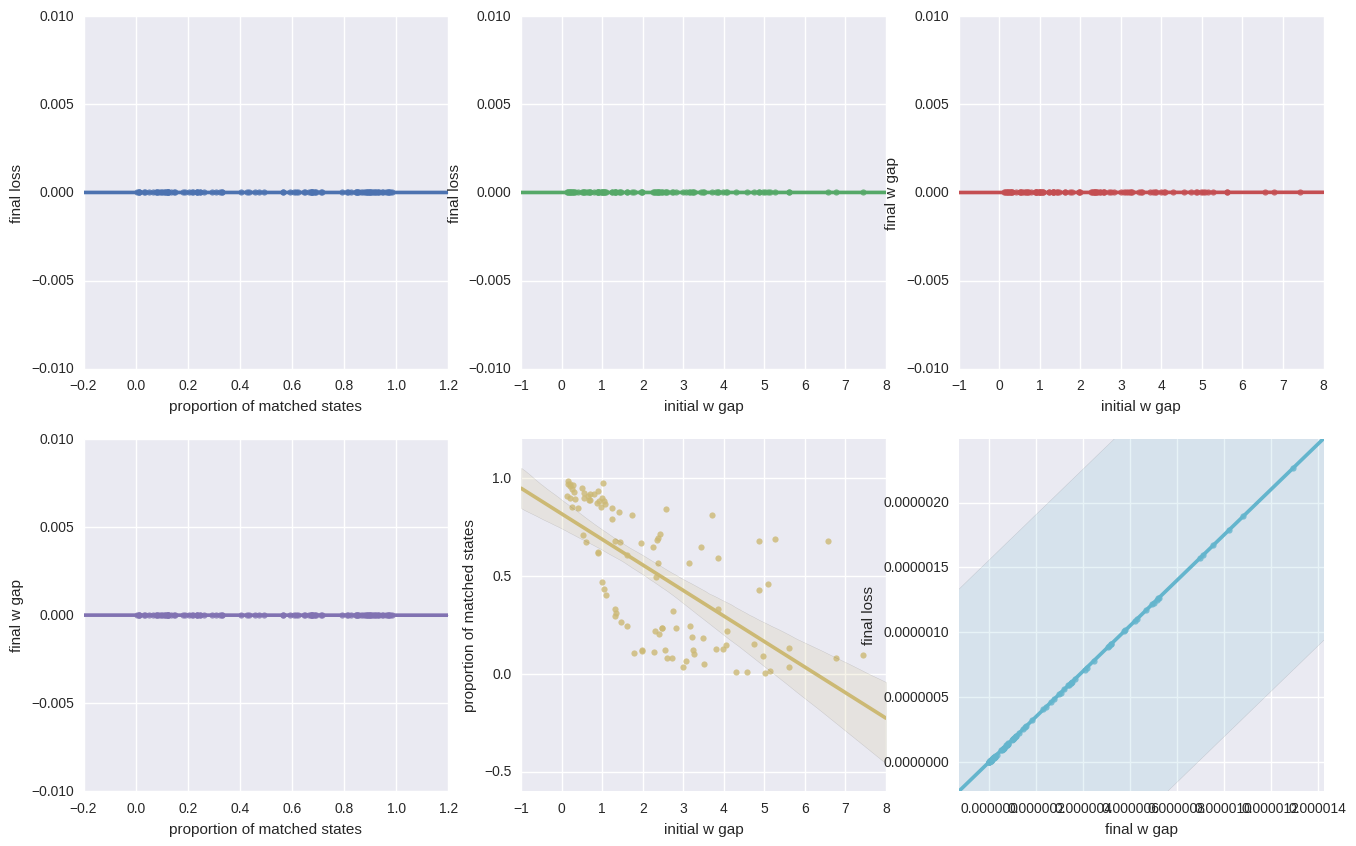

In [43]:
generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

In [ ]:
%matplotlib notebook
# Generate 3D plot
n = 100
all_wi = np.linspace(-2,2,n)
all_wj = np.linspace(-2,2,n)
L = compute_L(all_wi,all_wj)
plot_L_3D(all_wi,all_wj,L,w['weights'][0],w['weights'][1],0)

In [44]:
# Parameters
p = 10    # number of dimensions
N = 1000  # number of samples
q = 10    # rank of covariance matrix for generating samples
h = 1     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp_simple)
print(get_loss(X,Y,w,build_func=mlp_simple)) # Check to make sure optimal loss is 0

all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
    run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp_simple,plot=False)

0.0


Epoch 34/200 (0.367 s), batch 5.0/10 (0.004 s): loss 0.019, w gap: 0.277

Epoch 51/200 (0.569 s), batch 4.0/10 (0.004 s): loss 0.006, w gap: 0.199

Epoch 67/200 (0.768 s), batch 10.0/10 (0.010 s): loss 0.005, w gap: 0.153

Epoch 84/200 (0.973 s), batch 2.0/10 (0.001 s): loss 0.002, w gap: 0.126

Epoch 200/200 (2.758 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.079
Done with 1/100 (2.81 s elapsed)
Epoch 200/200 (2.632 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.428
Done with 2/100 (5.49 s elapsed)
Epoch 200/200 (2.629 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.961
Done with 3/100 (8.17 s elapsed)
Epoch 200/200 (2.635 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.134
Done with 4/100 (10.86 s elapsed)
Epoch 200/200 (2.817 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.038
Done with 5/100 (13.73 s elapsed)
Epoch 200/200 (2.647 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.463
Done with 6/100 (16.42 s elapsed)
Epoch 200/200 (2.767 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.403
Done with 7/100 (19.24 s elapsed)
Epoch 200/200 (2.684 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.193
Done with 8/100 (21.98 s elapsed)
Epoch 200/200 (2.659 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.527
Done with 9/100 (24.69 s elapsed)
Epoch 200/200 (2.695 s

Epoch 38/200 (0.419 s), batch 4.0/10 (0.003 s): loss 0.028, w gap: 0.394

Epoch 54/200 (0.619 s), batch 10.0/10 (0.008 s): loss 0.010, w gap: 0.298

Epoch 70/200 (0.824 s), batch 6.0/10 (0.005 s): loss 0.006, w gap: 0.257

Epoch 85/200 (1.024 s), batch 7.0/10 (0.008 s): loss 0.002, w gap: 0.238

Epoch 100/200 (1.220 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.229

Epoch 200/200 (2.845 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.220
Done with 75/100 (206.10 s elapsed)
Epoch 200/200 (2.668 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.042
Done with 76/100 (208.82 s elapsed)
Epoch 200/200 (2.656 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.157
Done with 77/100 (211.52 s elapsed)
Epoch 200/200 (2.651 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.100
Done with 78/100 (214.23 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.044
Done with 79/100 (217.10 s elapsed)
Epoch 200/200 (2.647 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 1.168
Done with 80/100 (219.80 s elapsed)
Epoch 200/200 (2.633 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.006
Done with 81/100 (222.49 s elapsed)
Epoch 200/200 (2.666 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.139
Done with 82/100 (225.20 s elapsed)
Epoch 200/200 (2.643 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.100
Done with 83/100 (227.97 s elapsed)
E

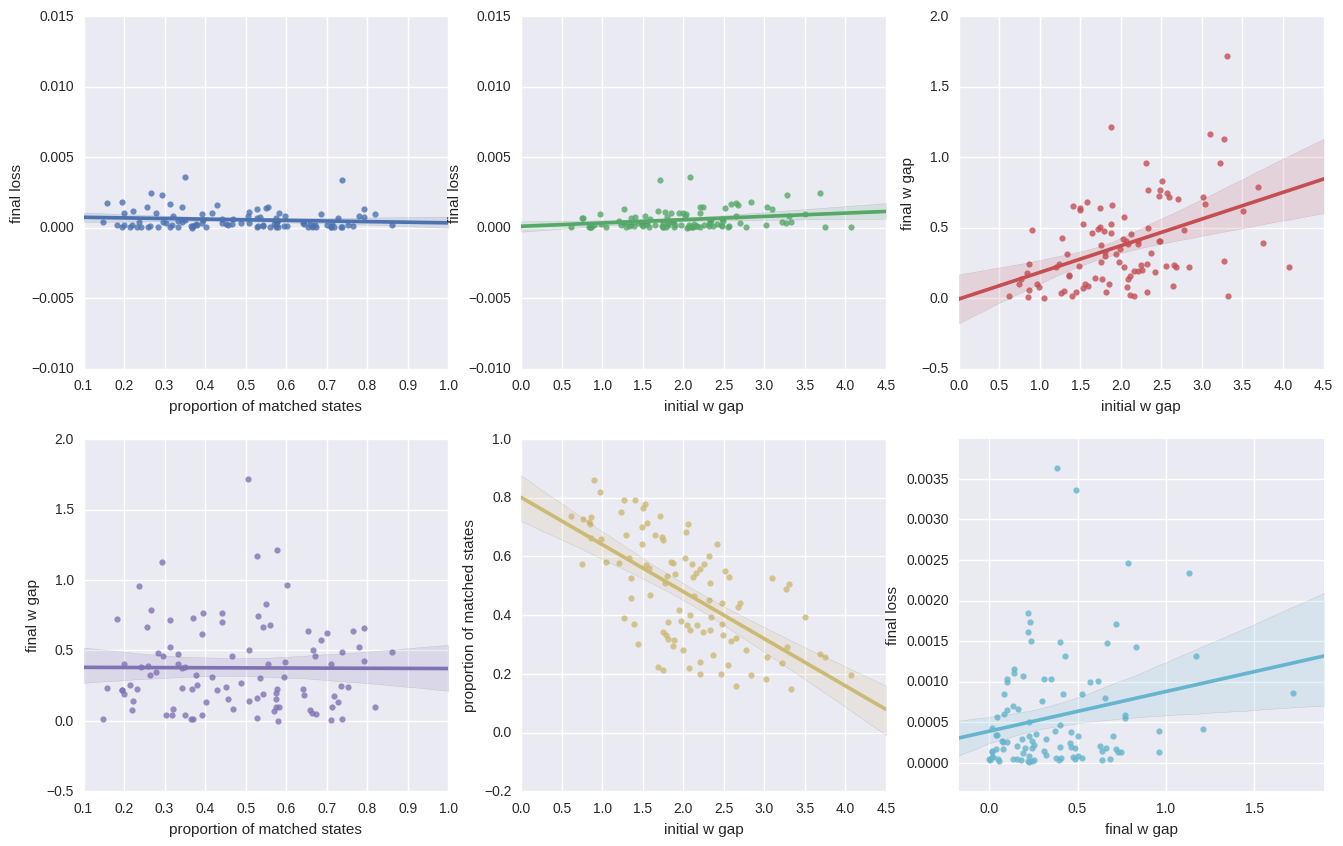

In [45]:
generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

### Experiment 3

Repeat experiment with no relu at last layer and fixed weights at last layer (3-layer)

In [47]:
def mlp_exp3(input_dict):
    p = input_dict['p']
    h = input_dict['h']
    mlp_in = tf.placeholder(tf.float32, shape=[None, p])
    weights1 = tf.get_variable('w1',initializer=tf.random_normal(shape=[p,h],
                                                                 stddev=1./np.sqrt(p)))
    mlp_hidden = tf.nn.relu(tf.matmul(mlp_in, weights1), name='mlp_hidden')
    weights2 = tf.get_variable('w2',initializer=tf.random_normal(shape=[h,1],
                                                                 stddev=1./np.sqrt(h)),trainable=False)
    mlp_out = tf.matmul(mlp_hidden, weights2)
    return dict(x=mlp_in,yhat=mlp_out,hid=mlp_hidden,weights1=weights1,weights2=weights2)

In [48]:
# Parameters
p = 10    # number of dimensions
N = 1000  # number of samples
q = 10    # rank of covariance matrix for generating samples
h = 3     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp_exp3)
print(get_loss(X,Y,w,build_func=mlp_exp3)) # Check to make sure optimal loss is 0

all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
    run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp_exp3,plot=False)

0.0


Epoch 31/200 (0.360 s), batch 1.0/10 (0.001 s): loss 0.041, w gap: 4.282

Epoch 48/200 (0.562 s), batch 9.0/10 (0.008 s): loss 0.020, w gap: 4.175

Epoch 65/200 (0.762 s), batch 10.0/10 (0.008 s): loss 0.014, w gap: 4.081

Epoch 81/200 (0.968 s), batch 6.0/10 (0.004 s): loss 0.012, w gap: 4.012

Epoch 95/200 (1.162 s), batch 10.0/10 (0.008 s): loss 0.010, w gap: 3.959

Epoch 110/200 (1.365 s), batch 10.0/10 (0.008 s): loss 0.010, w gap: 3.916

Epoch 125/200 (1.572 s), batch 3.0/10 (0.002 s): loss 0.008, w gap: 3.881

Epoch 138/200 (1.772 s), batch 10.0/10 (0.007 s): loss 0.006, w gap: 3.858

Epoch 152/200 (1.980 s), batch 6.0/10 (0.006 s): loss 0.006, w gap: 3.839

Epoch 164/200 (2.173 s), batch 10.0/10 (0.009 s): loss 0.005, w gap: 3.824

Epoch 178/200 (2.381 s), batch 2.0/10 (0.002 s): loss 0.003, w gap: 3.812

Epoch 190/200 (2.581 s), batch 5.0/10 (0.005 s): loss 0.004, w gap: 3.803

Epoch 200/200 (2.749 s), batch 10.0/10 (0.007 s): loss 0.003, w gap: 3.796
Done with 1/100 (2.81 s elapsed)
Epoch 200/200 (2.808 s), batch 10.0/10 (0.008 s): loss 0.010, w gap: 3.545
Done with 2/100 (5.69 s elapsed)
Epoch 200/200 (2.759 s), batch 10.0/10 (0.007 s): loss 0.177, w gap: 6.061
Done with 3/100 (8.51 s elapsed)
Epoch 200/200 (2.781 s), batch 10.0/10 (0.009 s): loss 0.013, w gap: 6.836
Done with 4/100 (11.36 s elapsed)
Epoch 200/200 (2.861 s), batch 10.0/10 (0.007 s): loss 0.026, w gap: 3.618
Done with 5/100 (14.28 s elapsed)
Epoch 200/200 (2.922 s), batch 10.0/10 (0.008 s): loss 0.014, w gap: 9.671
Done with 6/100 (17.26 s elapsed)
Epoch 200/200 (2.741 s), batch 10.0/10 (0.009 s): loss 0.010, w gap: 8.945
Done with 7/100 (20.07 s elapsed)
Epoch 200/200 (2.742 s), batch 10.0/10 (0.008 s): loss 0.070, w gap: 10.824
Done with 8/100 (22.87 s elapsed)
Epoch 200/200 (2.836 s), batch 10.0/10 (0.010 s): loss 0.064, w gap: 7.955
Done with 9/100 (25.78 s elapsed)
Epoch 200/200 (2.767 

Epoch 29/200 (0.356 s), batch 10.0/10 (0.009 s): loss 0.192, w gap: 5.839

Epoch 46/200 (0.560 s), batch 9.0/10 (0.007 s): loss 0.216, w gap: 5.530

Epoch 62/200 (0.761 s), batch 7.0/10 (0.005 s): loss 0.205, w gap: 5.372

Epoch 77/200 (0.959 s), batch 10.0/10 (0.007 s): loss 0.165, w gap: 5.266

Epoch 93/200 (1.165 s), batch 3.0/10 (0.003 s): loss 0.170, w gap: 5.181

Epoch 107/200 (1.361 s), batch 10.0/10 (0.010 s): loss 0.160, w gap: 5.112

Epoch 122/200 (1.567 s), batch 9.0/10 (0.007 s): loss 0.166, w gap: 5.090

Epoch 136/200 (1.768 s), batch 10.0/10 (0.007 s): loss 0.150, w gap: 5.068

Epoch 151/200 (1.975 s), batch 1.0/10 (0.001 s): loss 0.160, w gap: 5.048

Epoch 164/200 (2.176 s), batch 6.0/10 (0.004 s): loss 0.186, w gap: 5.028

Epoch 177/200 (2.376 s), batch 5.0/10 (0.004 s): loss 0.136, w gap: 5.012

Epoch 190/200 (2.577 s), batch 8.0/10 (0.006 s): loss 0.155, w gap: 4.995

Epoch 200/200 (2.737 s), batch 10.0/10 (0.007 s): loss 0.126, w gap: 4.983
Done with 75/100 (214.54 s elapsed)
Epoch 200/200 (2.881 s), batch 10.0/10 (0.010 s): loss 0.092, w gap: 7.954
Done with 76/100 (217.48 s elapsed)
Epoch 200/200 (2.750 s), batch 10.0/10 (0.008 s): loss 0.078, w gap: 9.132
Done with 77/100 (220.29 s elapsed)
Epoch 200/200 (2.752 s), batch 10.0/10 (0.010 s): loss 0.069, w gap: 7.499
Done with 78/100 (223.11 s elapsed)
Epoch 200/200 (2.799 s), batch 10.0/10 (0.009 s): loss 0.037, w gap: 9.409
Done with 79/100 (225.97 s elapsed)
Epoch 200/200 (2.889 s), batch 10.0/10 (0.008 s): loss 0.063, w gap: 5.828
Done with 80/100 (228.92 s elapsed)
Epoch 200/200 (2.749 s), batch 10.0/10 (0.007 s): loss 0.045, w gap: 8.162
Done with 81/100 (231.73 s elapsed)
Epoch 200/200 (2.768 s), batch 10.0/10 (0.007 s): loss 0.006, w gap: 3.297
Done with 82/100 (234.56 s elapsed)
Epoch 200/200 (2.874 s), batch 10.0/10 (0.009 s): loss 0.007, w gap: 8.859
Done with 83/100 (237.50 s elapsed)
E

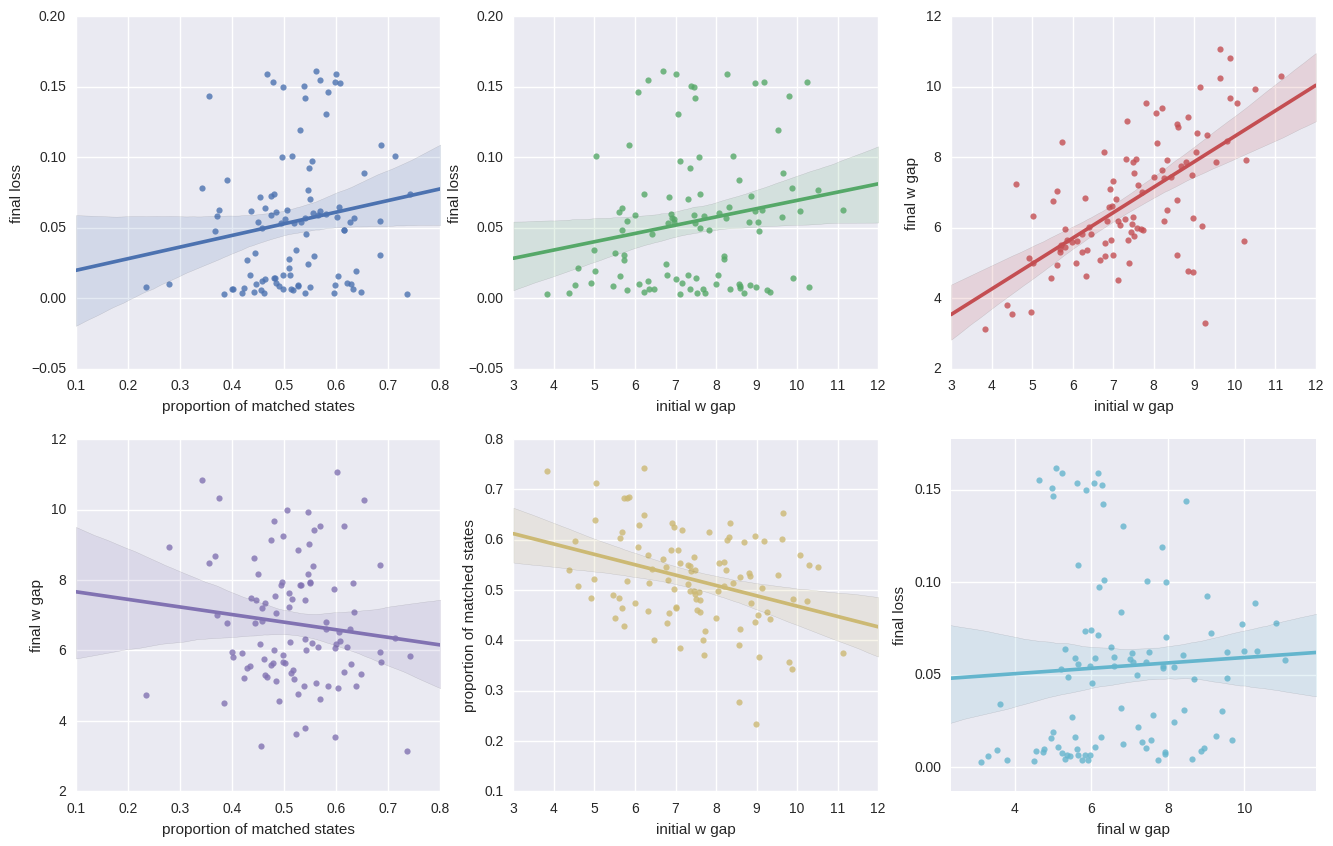

In [49]:
generate_all_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

### Experiment 4

Do slightly perturbed versions of $w^*$ converge to $w^*$?? (modify level of perturbation?)

In [64]:
p = 10    # number of dimensions
N = 1000  # number of samples
q = p     # rank of covariance matrix for generating samples
h = 3     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp)

list_init_perturb_w_true = [0.5,1.0,2.0,5.0,10.0]
losses = np.zeros((len(list_init_perturb_w_true),100))
for i,init_perturb_w_true in enumerate(list_init_perturb_w_true):

    all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
        run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp,plot=False,init_perturb_w_true=init_perturb_w_true)
        
    losses[i,:] = all_final_loss

Epoch 18/200 (0.223 s), batch 4.0/10 (0.003 s): loss 0.058, w gap: 7.429

Epoch 35/200 (0.423 s), batch 4.0/10 (0.003 s): loss 0.042, w gap: 7.198

Epoch 51/200 (0.624 s), batch 8.0/10 (0.006 s): loss 0.065, w gap: 7.023

Epoch 66/200 (0.821 s), batch 10.0/10 (0.008 s): loss 0.032, w gap: 6.869

Epoch 81/200 (1.021 s), batch 10.0/10 (0.008 s): loss 0.031, w gap: 6.737

Epoch 96/200 (1.227 s), batch 3.0/10 (0.003 s): loss 0.032, w gap: 6.621

Epoch 200/200 (2.959 s), batch 10.0/10 (0.008 s): loss 0.011, w gap: 6.022
Done with 1/100 (3.02 s elapsed)
Epoch 200/200 (2.846 s), batch 10.0/10 (0.008 s): loss 0.006, w gap: 9.301
Done with 2/100 (5.93 s elapsed)
Epoch 200/200 (2.830 s), batch 10.0/10 (0.008 s): loss 0.172, w gap: 14.054
Done with 3/100 (8.83 s elapsed)
Epoch 200/200 (2.825 s), batch 10.0/10 (0.009 s): loss 0.046, w gap: 8.454
Done with 4/100 (11.72 s elapsed)
Epoch 200/200 (2.844 s), batch 10.0/10 (0.007 s): loss 0.072, w gap: 8.064
Done with 5/100 (14.70 s elapsed)
Epoch 200/200 (2.851 s), batch 10.0/10 (0.007 s): loss 0.091, w gap: 14.490
Done with 6/100 (17.62 s elapsed)
Epoch 200/200 (2.835 s), batch 10.0/10 (0.008 s): loss 0.079, w gap: 14.331
Done with 7/100 (20.51 s elapsed)
Epoch 200/200 (3.052 s), batch 10.0/10 (0.008 s): loss 0.119, w gap: 16.702
Done with 8/100 (23.63 s elapsed)
Epoch 200/200 (2.813 s), batch 10.0/10 (0.009 s): loss 0.069, w gap: 11.455
Done with 9/100 (26.51 s elapsed)
Epoch 200/200 (2.

Epoch 19/200 (0.234 s), batch 6.0/10 (0.004 s): loss 0.121, w gap: 10.689

Epoch 35/200 (0.432 s), batch 10.0/10 (0.009 s): loss 0.122, w gap: 10.593

Epoch 51/200 (0.634 s), batch 10.0/10 (0.008 s): loss 0.127, w gap: 10.530

Epoch 67/200 (0.839 s), batch 3.0/10 (0.002 s): loss 0.132, w gap: 10.489

Epoch 81/200 (1.035 s), batch 10.0/10 (0.009 s): loss 0.112, w gap: 10.444

Epoch 96/200 (1.240 s), batch 1.0/10 (0.001 s): loss 0.101, w gap: 10.394

Epoch 109/200 (1.437 s), batch 10.0/10 (0.007 s): loss 0.098, w gap: 10.334

Epoch 123/200 (1.644 s), batch 4.0/10 (0.005 s): loss 0.095, w gap: 10.276

Epoch 136/200 (1.844 s), batch 3.0/10 (0.003 s): loss 0.100, w gap: 10.228

Epoch 148/200 (2.039 s), batch 10.0/10 (0.010 s): loss 0.081, w gap: 10.186

Epoch 161/200 (2.248 s), batch 6.0/10 (0.004 s): loss 0.122, w gap: 10.136

Epoch 173/200 (2.445 s), batch 10.0/10 (0.008 s): loss 0.083, w gap: 10.101

Epoch 186/200 (2.652 s), batch 4.0/10 (0.004 s): loss 0.104, w gap: 10.068

Epoch 198/200 (2.853 s), batch 5.0/10 (0.004 s): loss 0.079, w gap: 10.036

Epoch 200/200 (2.891 s), batch 10.0/10 (0.008 s): loss 0.068, w gap: 10.030
Done with 75/100 (221.80 s elapsed)
Epoch 200/200 (2.855 s), batch 10.0/10 (0.009 s): loss 0.055, w gap: 17.367
Done with 76/100 (224.72 s elapsed)
Epoch 200/200 (2.833 s), batch 10.0/10 (0.010 s): loss 0.052, w gap: 17.452
Done with 77/100 (227.62 s elapsed)
Epoch 200/200 (3.081 s), batch 10.0/10 (0.009 s): loss 0.058, w gap: 15.489
Done with 78/100 (230.76 s elapsed)
Epoch 200/200 (2.827 s), batch 10.0/10 (0.007 s): loss 0.118, w gap: 14.693
Done with 79/100 (233.66 s elapsed)
Epoch 200/200 (2.825 s), batch 10.0/10 (0.007 s): loss 0.049, w gap: 12.122
Done with 80/100 (236.55 s elapsed)
Epoch 200/200 (2.961 s), batch 10.0/10 (0.009 s): loss 0.113, w gap: 13.485
Done with 81/100 (239.57 s elapsed)
Epoch 200/200 (2.847 s), batch 10.0/10 (0.008 s): loss 0.018, w gap: 14.024
Done with 82/100 (242.49 s elapsed)
Epoch 200/200 (2.872 s), batch 10.0/10 (0.008 s): loss 0.006, w gap: 14.694
Done with 83/100 (245.42 s e

Epoch 18/200 (0.225 s), batch 10.0/10 (0.008 s): loss 0.043, w gap: 3.389

Epoch 35/200 (0.429 s), batch 1.0/10 (0.002 s): loss 0.033, w gap: 3.300

Epoch 51/200 (0.629 s), batch 3.0/10 (0.003 s): loss 0.026, w gap: 3.221

Epoch 66/200 (0.829 s), batch 9.0/10 (0.008 s): loss 0.028, w gap: 3.147

Epoch 81/200 (1.032 s), batch 6.0/10 (0.005 s): loss 0.019, w gap: 3.086

Epoch 96/200 (1.233 s), batch 7.0/10 (0.005 s): loss 0.023, w gap: 3.029

Epoch 110/200 (1.433 s), batch 3.0/10 (0.003 s): loss 0.019, w gap: 2.976

Epoch 124/200 (1.634 s), batch 7.0/10 (0.007 s): loss 0.017, w gap: 2.926

Epoch 137/200 (1.829 s), batch 10.0/10 (0.007 s): loss 0.015, w gap: 2.884

Epoch 150/200 (2.029 s), batch 10.0/10 (0.010 s): loss 0.017, w gap: 2.847

Epoch 163/200 (2.231 s), batch 10.0/10 (0.007 s): loss 0.011, w gap: 2.812

Epoch 176/200 (2.435 s), batch 10.0/10 (0.009 s): loss 0.012, w gap: 2.780

Epoch 189/200 (2.644 s), batch 10.0/10 (0.008 s): loss 0.015, w gap: 2.750

Epoch 200/200 (2.824 s), batch 10.0/10 (0.008 s): loss 0.012, w gap: 2.726
Done with 49/100 (144.42 s elapsed)
Epoch 200/200 (2.806 s), batch 10.0/10 (0.008 s): loss 0.043, w gap: 5.004
Done with 50/100 (147.30 s elapsed)
Epoch 200/200 (3.071 s), batch 10.0/10 (0.009 s): loss 0.003, w gap: 1.360
Done with 51/100 (150.44 s elapsed)
Epoch 200/200 (2.853 s), batch 10.0/10 (0.008 s): loss 0.045, w gap: 3.462
Done with 52/100 (153.36 s elapsed)
Epoch 200/200 (2.818 s), batch 10.0/10 (0.008 s): loss 0.006, w gap: 4.331
Done with 53/100 (156.24 s elapsed)
Epoch 200/200 (2.813 s), batch 10.0/10 (0.008 s): loss 0.009, w gap: 2.510
Done with 54/100 (159.12 s elapsed)
Epoch 200/200 (3.002 s), batch 10.0/10 (0.007 s): loss 0.010, w gap: 2.534
Done with 55/100 (162.19 s elapsed)
Epoch 200/200 (2.834 s), batch 10.0/10 (0.010 s): loss 0.002, w gap: 2.741
Done with 56/100 (165.08 s elapsed)
Epoch 200/200 (2.843 s), batch 10.0/10 (0.008 s): loss 0.015, w gap: 3.064
Done with 57/100 (167.99 s elapsed)
E

Epoch 35/200 (0.422 s), batch 10.0/10 (0.008 s): loss 0.012, w gap: 1.089

Epoch 52/200 (0.627 s), batch 1.0/10 (0.001 s): loss 0.006, w gap: 1.049

Epoch 67/200 (0.827 s), batch 5.0/10 (0.004 s): loss 0.005, w gap: 1.028

Epoch 82/200 (1.027 s), batch 10.0/10 (0.009 s): loss 0.002, w gap: 1.015

Epoch 97/200 (1.233 s), batch 5.0/10 (0.004 s): loss 0.002, w gap: 1.005

Epoch 111/200 (1.434 s), batch 5.0/10 (0.005 s): loss 0.002, w gap: 0.998

Epoch 125/200 (1.635 s), batch 7.0/10 (0.006 s): loss 0.001, w gap: 0.991

Epoch 138/200 (1.835 s), batch 5.0/10 (0.006 s): loss 0.001, w gap: 0.986

Epoch 151/200 (2.035 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.981

Epoch 164/200 (2.237 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.976

Epoch 177/200 (2.440 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.972

Epoch 190/200 (2.649 s), batch 7.0/10 (0.006 s): loss 0.001, w gap: 0.969

Epoch 200/200 (2.814 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.966
Done with 23/100 (67.66 s elapsed)
Epoch 200/200 (2.847 s), batch 10.0/10 (0.010 s): loss 0.003, w gap: 0.748
Done with 24/100 (70.57 s elapsed)
Epoch 200/200 (2.851 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.459
Done with 25/100 (73.56 s elapsed)
Epoch 200/200 (2.870 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.457
Done with 26/100 (76.50 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.009 s): loss 0.002, w gap: 0.285
Done with 27/100 (79.39 s elapsed)
Epoch 200/200 (3.097 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.487
Done with 28/100 (82.55 s elapsed)
Epoch 200/200 (2.844 s), batch 10.0/10 (0.008 s): loss 0.002, w gap: 0.467
Done with 29/100 (85.46 s elapsed)
Epoch 200/200 (2.849 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.282
Done with 30/100 (88.37 s elapsed)
Epoch 200/200 (2.848 s), batch 10.0/10 (0.012 s): loss 0.000, w gap: 0.480
Done with 31/100 (91.29 s elapsed)
Epoch 200/

Epoch 28/200 (0.358 s), batch 2.0/10 (0.002 s): loss 0.006, w gap: 0.546

Epoch 44/200 (0.554 s), batch 10.0/10 (0.007 s): loss 0.004, w gap: 0.520

Epoch 60/200 (0.756 s), batch 10.0/10 (0.007 s): loss 0.003, w gap: 0.501

Epoch 75/200 (0.960 s), batch 10.0/10 (0.008 s): loss 0.003, w gap: 0.486

Epoch 90/200 (1.160 s), batch 10.0/10 (0.008 s): loss 0.002, w gap: 0.473

Epoch 105/200 (1.366 s), batch 3.0/10 (0.002 s): loss 0.002, w gap: 0.463

Epoch 119/200 (1.567 s), batch 3.0/10 (0.002 s): loss 0.002, w gap: 0.454

Epoch 132/200 (1.768 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.446

Epoch 146/200 (1.975 s), batch 6.0/10 (0.006 s): loss 0.001, w gap: 0.439

Epoch 158/200 (2.169 s), batch 10.0/10 (0.012 s): loss 0.001, w gap: 0.433

Epoch 172/200 (2.377 s), batch 6.0/10 (0.004 s): loss 0.001, w gap: 0.426

Epoch 185/200 (2.577 s), batch 7.0/10 (0.005 s): loss 0.001, w gap: 0.421

Epoch 198/200 (2.778 s), batch 1.0/10 (0.001 s): loss 0.001, w gap: 0.416

Epoch 200/200 (2.817 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.415
Done with 97/100 (286.32 s elapsed)
Epoch 200/200 (3.071 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.710
Done with 98/100 (289.46 s elapsed)
Epoch 200/200 (2.827 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.320
Done with 99/100 (292.35 s elapsed)
Epoch 200/200 (2.854 s), batch 10.0/10 (0.008 s): loss 0.011, w gap: 0.480
Done with 100/100 (295.27 s elapsed)
Epoch 200/200 (2.962 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.080
Done with 1/100 (3.03 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.073
Done with 2/100 (5.94 s elapsed)
Epoch 200/200 (2.839 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.057
Done with 3/100 (8.84 s elapsed)
Epoch 200/200 (2.829 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.063
Done with 4/100 (11.73 s elapsed)
Epoch 200/200 (3.008 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.048
Done with 5/100 (14.81 s elapsed)
Epoch 200/200

Epoch 35/200 (0.426 s), batch 2.0/10 (0.002 s): loss 0.001, w gap: 0.102

Epoch 50/200 (0.625 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.099

Epoch 65/200 (0.826 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.097

Epoch 80/200 (1.031 s), batch 5.0/10 (0.006 s): loss 0.000, w gap: 0.096

Epoch 94/200 (1.228 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.095

Epoch 109/200 (1.433 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.093

Epoch 123/200 (1.638 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.092

Epoch 137/200 (1.843 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.092

Epoch 200/200 (3.000 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.089
Done with 71/100 (209.40 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.163
Done with 72/100 (212.28 s elapsed)
Epoch 200/200 (2.842 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.077
Done with 73/100 (215.19 s elapsed)
Epoch 200/200 (2.805 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.119
Done with 74/100 (218.07 s elapsed)
Epoch 200/200 (2.940 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.050
Done with 75/100 (221.07 s elapsed)
Epoch 200/200 (2.810 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.062
Done with 76/100 (223.95 s elapsed)
Epoch 200/200 (2.851 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.101
Done with 77/100 (226.86 s elapsed)
Epoch 200/200 (3.021 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.062
Done with 78/100 (229.95 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.060
Done with 79/100 (232.86 s elapsed)
E

Epoch 23/200 (0.281 s), batch 7.0/10 (0.005 s): loss 0.001, w gap: 0.026

Epoch 39/200 (0.481 s), batch 9.0/10 (0.008 s): loss 0.000, w gap: 0.023

Epoch 55/200 (0.679 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.021

Epoch 71/200 (0.886 s), batch 8.0/10 (0.007 s): loss 0.000, w gap: 0.019

Epoch 86/200 (1.086 s), batch 1.0/10 (0.001 s): loss 0.000, w gap: 0.018

Epoch 100/200 (1.287 s), batch 3.0/10 (0.003 s): loss 0.000, w gap: 0.017

Epoch 113/200 (1.481 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.016

Epoch 127/200 (1.682 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.016

Epoch 140/200 (1.883 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.015

Epoch 154/200 (2.092 s), batch 4.0/10 (0.003 s): loss 0.000, w gap: 0.015

Epoch 166/200 (2.288 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.014

Epoch 179/200 (2.495 s), batch 8.0/10 (0.010 s): loss 0.000, w gap: 0.014

Epoch 191/200 (2.697 s), batch 7.0/10 (0.007 s): loss 0.000, w gap: 0.013

Epoch 200/200 (2.850 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.013
Done with 45/100 (132.96 s elapsed)
Epoch 200/200 (2.826 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.019
Done with 46/100 (135.86 s elapsed)
Epoch 200/200 (2.836 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.027
Done with 47/100 (138.76 s elapsed)
Epoch 200/200 (3.088 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.030
Done with 48/100 (141.92 s elapsed)
Epoch 200/200 (2.833 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.014
Done with 49/100 (144.81 s elapsed)
Epoch 200/200 (2.861 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.015
Done with 50/100 (147.74 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.022
Done with 51/100 (150.65 s elapsed)
Epoch 200/200 (2.866 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.036
Done with 52/100 (153.66 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.029
Done with 53/100 (156.55 s elapsed)
E

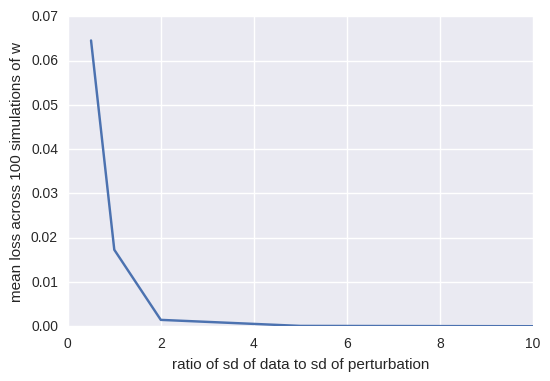

In [65]:
plt.plot(list_init_perturb_w_true,np.mean(losses,1))
plt.xlabel('ratio of sd of data to sd of perturbation')
plt.ylabel('mean loss across 100 simulations of w')

In [66]:
p = 10    # number of dimensions
N = 1000  # number of samples
q = p     # rank of covariance matrix for generating samples
h = 1     # number of hidden units

input_dict = dict(p=p,h=h)
X,Y,hs,w = generate_data(N,q,input_dict,seed=0,build_func=mlp)

list_init_perturb_w_true = [0.5,1.0,2.0,5.0,10.0]
losses = np.zeros((len(list_init_perturb_w_true),100))
for i,init_perturb_w_true in enumerate(list_init_perturb_w_true):

    all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps = \
        run_experiment(X,Y,hs,w,input_dict,100,build_func=mlp,plot=False,init_perturb_w_true=init_perturb_w_true)
        
    losses[i,:] = all_final_loss

Epoch 18/200 (0.223 s), batch 8.0/10 (0.006 s): loss 0.005, w gap: 2.362

Epoch 34/200 (0.423 s), batch 10.0/10 (0.009 s): loss 0.003, w gap: 2.307

Epoch 50/200 (0.625 s), batch 10.0/10 (0.008 s): loss 0.003, w gap: 2.270

Epoch 66/200 (0.831 s), batch 8.0/10 (0.007 s): loss 0.002, w gap: 2.242

Epoch 80/200 (1.026 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 2.222

Epoch 95/200 (1.232 s), batch 7.0/10 (0.007 s): loss 0.002, w gap: 2.206

Epoch 109/200 (1.429 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 2.193

Epoch 123/200 (1.630 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 2.183

Epoch 137/200 (1.837 s), batch 7.0/10 (0.006 s): loss 0.001, w gap: 2.175

Epoch 150/200 (2.036 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 2.168

Epoch 163/200 (2.241 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 2.162

Epoch 176/200 (2.450 s), batch 8.0/10 (0.006 s): loss 0.000, w gap: 2.158

Epoch 188/200 (2.651 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 2.154

Epoch 200/200 (2.851 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 2.151


Done with 1/100 (2.92 s elapsed)


Epoch 29/200 (0.352 s), batch 10.0/10 (0.009 s): loss 0.055, w gap: 2.589

Epoch 46/200 (0.556 s), batch 5.0/10 (0.004 s): loss 0.039, w gap: 2.414

Epoch 61/200 (0.754 s), batch 10.0/10 (0.007 s): loss 0.035, w gap: 2.284

Epoch 77/200 (0.959 s), batch 3.0/10 (0.002 s): loss 0.034, w gap: 2.182

Epoch 91/200 (1.154 s), batch 10.0/10 (0.007 s): loss 0.032, w gap: 2.098

Epoch 106/200 (1.359 s), batch 10.0/10 (0.007 s): loss 0.023, w gap: 2.025

Epoch 121/200 (1.566 s), batch 1.0/10 (0.001 s): loss 0.022, w gap: 1.965

Epoch 134/200 (1.764 s), batch 10.0/10 (0.007 s): loss 0.014, w gap: 1.913

Epoch 148/200 (1.971 s), batch 2.0/10 (0.001 s): loss 0.015, w gap: 1.869

Epoch 161/200 (2.172 s), batch 4.0/10 (0.003 s): loss 0.020, w gap: 1.828

Epoch 173/200 (2.367 s), batch 10.0/10 (0.009 s): loss 0.021, w gap: 1.793

Epoch 186/200 (2.576 s), batch 8.0/10 (0.007 s): loss 0.015, w gap: 1.760

Epoch 198/200 (2.772 s), batch 10.0/10 (0.007 s): loss 0.009, w gap: 1.730

Epoch 200/200 (2.806 s), batch 10.0/10 (0.010 s): loss 0.019, w gap: 1.725
Done with 2/100 (5.79 s elapsed)
Epoch 200/200 (2.804 s), batch 10.0/10 (0.010 s): loss 0.153, w gap: 11.760
Done with 3/100 (8.66 s elapsed)
Epoch 200/200 (2.860 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 1.059
Done with 4/100 (11.67 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.007 s): loss 0.005, w gap: 1.593
Done with 5/100 (14.58 s elapsed)
Epoch 200/200 (3.060 s), batch 10.0/10 (0.008 s): loss 0.006, w gap: 1.459
Done with 6/100 (17.70 s elapsed)
Epoch 200/200 (3.132 s), batch 10.0/10 (0.009 s): loss 0.010, w gap: 3.491
Done with 7/100 (20.90 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.008 s): loss 0.200, w gap: 8.491
Done with 8/100 (23.79 s elapsed)
Epoch 200/200 (2.840 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 3.115
Done with 9/100 (26.70 s elapsed)
Epoch 200/200 (2.842 s), batch 10.0/10 (0.008 s): loss 0.138, w gap: 22.513
Done with 10/100 (29.61 s elapsed)
Epoch 200/200 (2.8

Epoch 35/200 (0.427 s), batch 10.0/10 (0.008 s): loss 0.328, w gap: 4.744

Epoch 51/200 (0.632 s), batch 10.0/10 (0.007 s): loss 0.227, w gap: 4.744

Epoch 67/200 (0.837 s), batch 1.0/10 (0.002 s): loss 0.223, w gap: 4.744

Epoch 81/200 (1.038 s), batch 7.0/10 (0.005 s): loss 0.302, w gap: 4.744

Epoch 95/200 (1.233 s), batch 10.0/10 (0.012 s): loss 0.312, w gap: 4.744

Epoch 110/200 (1.440 s), batch 7.0/10 (0.006 s): loss 0.304, w gap: 4.744

Epoch 124/200 (1.637 s), batch 10.0/10 (0.008 s): loss 0.168, w gap: 4.744

Epoch 138/200 (1.844 s), batch 10.0/10 (0.008 s): loss 0.223, w gap: 4.744

Epoch 152/200 (2.051 s), batch 3.0/10 (0.002 s): loss 0.245, w gap: 4.744

Epoch 165/200 (2.252 s), batch 1.0/10 (0.001 s): loss 0.334, w gap: 4.744

Epoch 177/200 (2.449 s), batch 10.0/10 (0.009 s): loss 0.279, w gap: 4.744

Epoch 190/200 (2.658 s), batch 7.0/10 (0.005 s): loss 0.185, w gap: 4.744

Epoch 200/200 (2.821 s), batch 10.0/10 (0.009 s): loss 0.172, w gap: 4.744
Done with 76/100 (224.57 s elapsed)
Epoch 200/200 (3.065 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 3.091
Done with 77/100 (227.70 s elapsed)
Epoch 200/200 (2.821 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 9.266
Done with 78/100 (230.59 s elapsed)
Epoch 200/200 (2.837 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.559
Done with 79/100 (233.49 s elapsed)
Epoch 200/200 (2.963 s), batch 10.0/10 (0.010 s): loss 0.358, w gap: 5.218
Done with 80/100 (236.52 s elapsed)
Epoch 200/200 (2.862 s), batch 10.0/10 (0.010 s): loss 0.319, w gap: 11.947
Done with 81/100 (239.45 s elapsed)
Epoch 200/200 (2.850 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 9.792
Done with 82/100 (242.37 s elapsed)
Epoch 200/200 (2.849 s), batch 10.0/10 (0.008 s): loss 0.223, w gap: 13.735
Done with 83/100 (245.28 s elapsed)
Epoch 200/200 (3.027 s), batch 10.0/10 (0.007 s): loss 0.013, w gap: 4.793
Done with 84/100 (248.38 s elapsed)

Epoch 29/200 (0.356 s), batch 6.0/10 (0.006 s): loss 0.210, w gap: 2.414

Epoch 45/200 (0.557 s), batch 6.0/10 (0.004 s): loss 0.208, w gap: 2.414

Epoch 60/200 (0.755 s), batch 10.0/10 (0.009 s): loss 0.266, w gap: 2.414

Epoch 76/200 (0.960 s), batch 1.0/10 (0.001 s): loss 0.218, w gap: 2.414

Epoch 89/200 (1.157 s), batch 10.0/10 (0.008 s): loss 0.243, w gap: 2.414

Epoch 104/200 (1.359 s), batch 10.0/10 (0.008 s): loss 0.213, w gap: 2.414

Epoch 119/200 (1.566 s), batch 2.0/10 (0.003 s): loss 0.243, w gap: 2.414

Epoch 132/200 (1.766 s), batch 7.0/10 (0.006 s): loss 0.169, w gap: 2.414

Epoch 200/200 (3.020 s), batch 10.0/10 (0.010 s): loss 0.215, w gap: 2.414
Done with 50/100 (147.83 s elapsed)
Epoch 200/200 (2.833 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.179
Done with 51/100 (150.73 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.007 s): loss 0.182, w gap: 1.449
Done with 52/100 (153.64 s elapsed)
Epoch 200/200 (2.819 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.502
Done with 53/100 (156.53 s elapsed)
Epoch 200/200 (3.069 s), batch 10.0/10 (0.008 s): loss 0.007, w gap: 0.932
Done with 54/100 (159.66 s elapsed)
Epoch 200/200 (2.841 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 2.326
Done with 55/100 (162.57 s elapsed)
Epoch 200/200 (3.028 s), batch 10.0/10 (0.010 s): loss 0.009, w gap: 1.780
Done with 56/100 (165.66 s elapsed)
Epoch 200/200 (3.010 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.195
Done with 57/100 (168.74 s elapsed)
Epoch 200/200 (2.856 s), batch 10.0/10 (0.009 s): loss 0.003, w gap: 0.808
Done with 58/100 (171.66 s elapsed)
E

Epoch 34/200 (0.423 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.048

Epoch 50/200 (0.628 s), batch 3.0/10 (0.002 s): loss 0.000, w gap: 0.045

Epoch 65/200 (0.829 s), batch 8.0/10 (0.008 s): loss 0.000, w gap: 0.043

Epoch 80/200 (1.030 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.042

Epoch 95/200 (1.236 s), batch 5.0/10 (0.006 s): loss 0.000, w gap: 0.041

Epoch 109/200 (1.436 s), batch 6.0/10 (0.004 s): loss 0.000, w gap: 0.041

Epoch 123/200 (1.638 s), batch 6.0/10 (0.005 s): loss 0.000, w gap: 0.040

Epoch 136/200 (1.834 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.040

Epoch 150/200 (2.041 s), batch 2.0/10 (0.002 s): loss 0.000, w gap: 0.040

Epoch 162/200 (2.235 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.039

Epoch 175/200 (2.443 s), batch 8.0/10 (0.007 s): loss 0.000, w gap: 0.039

Epoch 187/200 (2.642 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.039

Epoch 199/200 (2.844 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.039

Epoch 200/200 (2.861 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.039
Done with 24/100 (70.89 s elapsed)
Epoch 200/200 (2.842 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.050
Done with 25/100 (73.80 s elapsed)
Epoch 200/200 (2.815 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.041
Done with 26/100 (76.68 s elapsed)
Epoch 200/200 (3.082 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.119
Done with 27/100 (79.83 s elapsed)
Epoch 200/200 (2.834 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.026
Done with 28/100 (82.73 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.276
Done with 29/100 (85.62 s elapsed)
Epoch 200/200 (2.836 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.148
Done with 30/100 (88.54 s elapsed)
Epoch 200/200 (2.830 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.515
Done with 31/100 (91.52 s elapsed)
Epoch 200/200 (3.042 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.366
Done with 32/100 (94.63 s elapsed)
Epoch 200/

Epoch 21/200 (0.258 s), batch 7.0/10 (0.007 s): loss 0.007, w gap: 0.264

Epoch 38/200 (0.458 s), batch 1.0/10 (0.001 s): loss 0.003, w gap: 0.226

Epoch 54/200 (0.659 s), batch 3.0/10 (0.003 s): loss 0.002, w gap: 0.206

Epoch 69/200 (0.860 s), batch 2.0/10 (0.002 s): loss 0.001, w gap: 0.195

Epoch 83/200 (1.059 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.188

Epoch 98/200 (1.260 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.183

Epoch 113/200 (1.466 s), batch 9.0/10 (0.008 s): loss 0.000, w gap: 0.180

Epoch 127/200 (1.666 s), batch 2.0/10 (0.002 s): loss 0.000, w gap: 0.178

Epoch 140/200 (1.868 s), batch 7.0/10 (0.007 s): loss 0.000, w gap: 0.176

Epoch 153/200 (2.068 s), batch 5.0/10 (0.005 s): loss 0.000, w gap: 0.175

Epoch 165/200 (2.262 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.174

Epoch 178/200 (2.470 s), batch 5.0/10 (0.004 s): loss 0.000, w gap: 0.174

Epoch 190/200 (2.668 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.173

Epoch 200/200 (2.832 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.173
Done with 98/100 (289.96 s elapsed)
Epoch 200/200 (2.830 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.276
Done with 99/100 (292.85 s elapsed)
Epoch 200/200 (2.984 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.011
Done with 100/100 (295.90 s elapsed)
Epoch 200/200 (2.832 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.079
Done with 1/100 (2.90 s elapsed)
Epoch 200/200 (2.854 s), batch 10.0/10 (0.013 s): loss 0.000, w gap: 0.013
Done with 2/100 (5.82 s elapsed)
Epoch 200/200 (2.808 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.006
Done with 3/100 (8.69 s elapsed)
Epoch 200/200 (2.998 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.011
Done with 4/100 (11.76 s elapsed)
Epoch 200/200 (2.810 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.004
Done with 5/100 (14.63 s elapsed)
Epoch 200/200 (2.815 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.012
Done with 6/100 (17.51 s elapsed)
Epoch 200/200 (

Epoch 34/200 (0.427 s), batch 7.0/10 (0.006 s): loss 0.000, w gap: 0.089

Epoch 50/200 (0.628 s), batch 7.0/10 (0.005 s): loss 0.000, w gap: 0.088

Epoch 65/200 (0.826 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.087

Epoch 80/200 (1.028 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.086

Epoch 95/200 (1.234 s), batch 7.0/10 (0.007 s): loss 0.000, w gap: 0.086

Epoch 109/200 (1.434 s), batch 5.0/10 (0.004 s): loss 0.000, w gap: 0.086

Epoch 122/200 (1.629 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.086

Epoch 136/200 (1.836 s), batch 9.0/10 (0.008 s): loss 0.000, w gap: 0.086

Epoch 149/200 (2.031 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.085

Epoch 163/200 (2.238 s), batch 5.0/10 (0.004 s): loss 0.000, w gap: 0.085

Epoch 176/200 (2.440 s), batch 3.0/10 (0.002 s): loss 0.000, w gap: 0.085

Epoch 188/200 (2.634 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.085

Epoch 200/200 (2.835 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.085


Done with 72/100 (212.41 s elapsed)


Epoch 30/200 (0.357 s), batch 6.0/10 (0.006 s): loss 0.001, w gap: 0.018

Epoch 45/200 (0.558 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.015

Epoch 61/200 (0.762 s), batch 6.0/10 (0.006 s): loss 0.000, w gap: 0.013

Epoch 75/200 (0.959 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.011

Epoch 90/200 (1.165 s), batch 9.0/10 (0.009 s): loss 0.000, w gap: 0.010

Epoch 104/200 (1.366 s), batch 8.0/10 (0.006 s): loss 0.000, w gap: 0.010

Epoch 118/200 (1.567 s), batch 2.0/10 (0.003 s): loss 0.000, w gap: 0.009

Epoch 131/200 (1.763 s), batch 10.0/10 (0.011 s): loss 0.000, w gap: 0.009

Epoch 145/200 (1.968 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.008

Epoch 159/200 (2.176 s), batch 7.0/10 (0.006 s): loss 0.000, w gap: 0.008

Epoch 172/200 (2.375 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.008

Epoch 185/200 (2.580 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.008

Epoch 198/200 (2.789 s), batch 1.0/10 (0.001 s): loss 0.000, w gap: 0.008

Epoch 200/200 (2.827 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.008
Done with 73/100 (215.30 s elapsed)
Epoch 200/200 (2.859 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.006
Done with 74/100 (218.31 s elapsed)
Epoch 200/200 (2.821 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.003
Done with 75/100 (221.19 s elapsed)
Epoch 200/200 (2.824 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.011
Done with 76/100 (224.08 s elapsed)
Epoch 200/200 (3.067 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.006
Done with 77/100 (227.22 s elapsed)
Epoch 200/200 (2.834 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.005
Done with 78/100 (230.12 s elapsed)
Epoch 200/200 (2.839 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.041
Done with 79/100 (233.02 s elapsed)
Epoch 200/200 (2.817 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.013
Done with 80/100 (235.90 s elapsed)
Epoch 200/200 (2.851 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.021
Done with 81/100 (238.90 s elapsed)
E

Epoch 24/200 (0.311 s), batch 3.0/10 (0.002 s): loss 0.001, w gap: 0.007

Epoch 40/200 (0.512 s), batch 4.0/10 (0.003 s): loss 0.000, w gap: 0.005

Epoch 56/200 (0.713 s), batch 3.0/10 (0.002 s): loss 0.000, w gap: 0.004

Epoch 70/200 (0.910 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.003

Epoch 83/200 (1.192 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.003

Epoch 96/200 (1.398 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.003

Epoch 109/200 (1.606 s), batch 6.0/10 (0.005 s): loss 0.000, w gap: 0.002

Epoch 121/200 (1.807 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.002

Epoch 133/200 (2.008 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.002

Epoch 145/200 (2.218 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.002

Epoch 157/200 (2.428 s), batch 4.0/10 (0.004 s): loss 0.000, w gap: 0.002

Epoch 168/200 (2.620 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.002

Epoch 180/200 (2.822 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.002

Epoch 192/200 (3.029 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.002

Epoch 200/200 (3.163 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.002
Done with 47/100 (139.10 s elapsed)
Epoch 200/200 (2.847 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.004
Done with 48/100 (142.01 s elapsed)
Epoch 200/200 (2.836 s), batch 10.0/10 (0.010 s): loss 0.000, w gap: 0.003
Done with 49/100 (144.92 s elapsed)
Epoch 200/200 (2.912 s), batch 10.0/10 (0.007 s): loss 0.000, w gap: 0.006
Done with 50/100 (147.90 s elapsed)
Epoch 200/200 (2.872 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.009
Done with 51/100 (150.83 s elapsed)
Epoch 200/200 (2.815 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.002
Done with 52/100 (153.71 s elapsed)
Epoch 200/200 (2.834 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.003
Done with 53/100 (156.62 s elapsed)
Epoch 200/200 (3.110 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.004
Done with 54/100 (159.79 s elapsed)
Epoch 200/200 (2.840 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.001
Done with 55/100 (162.70 s elapsed)
E

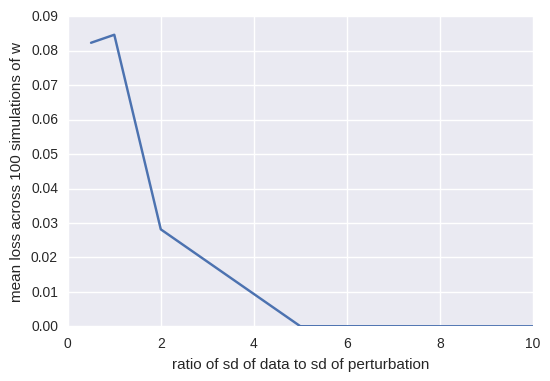

In [67]:
plt.plot(list_init_perturb_w_true,np.mean(losses,1))
plt.xlabel('ratio of sd of data to sd of perturbation')
plt.ylabel('mean loss across 100 simulations of w')

### Experiment 5

Try 2 layer net with 3 input nodes, 1 hidden node. Set $w^*$ to [1 -0.5 0.5], plot the obtained w*’s

In [ ]:
# Parameters
p = 3    # number of dimensions
N = 1000  # number of samples
q = 3    # rank of covariance matrix for generating samples
h = 1     # number of hidden units

input_dict = dict(p=p,h=h)
X = generate_X(N,q,input_dict)
w = {'weights': np.array([[1.0],[-0.5],[0.5]])}
Y = generate_output(X,w,build_func=mlp_simple,batch_size=100)
hs = get_hidden_states(X,input_dict,w,build_func=mlp_simple)
print(get_loss(X,Y,w,build_func=mlp_simple)) # Check to make sure optimal loss is 0

final_weights = np.zeros((100,p))
start = time.time()

for t in range(100):
    
    # Initialize weights
    weights = {k:np.random.normal(0,1./np.sqrt(np.shape(w[k])[0]),
                                          np.shape(w[k])) for k in w}

    # Run gradient descent
    tf.reset_default_graph()
    graph = graph_builder_wrapper(input_dict,build_func=mlp_simple)
    training_losses,training_w_gaps,w_hat,initial_train_loss,initial_train_w_gap,final_train_loss,final_w_gap = \
            train(X,Y,graph,200,100,w,w_initial=weights)
        
    final_weights[t] = w_hat['weights'].reshape(-1)
        
    print('%s/%s (%.2f elapsed)'%(t+1,100,time.time()-start))

0.0


Epoch 35/200 (0.381 s), batch 2.0/10 (0.001 s): loss 0.008, w gap: 0.733

Epoch 52/200 (0.580 s), batch 10.0/10 (0.007 s): loss 0.006, w gap: 0.693

Epoch 70/200 (0.785 s), batch 5.0/10 (0.003 s): loss 0.007, w gap: 0.656

Epoch 87/200 (0.985 s), batch 6.0/10 (0.004 s): loss 0.005, w gap: 0.622

Epoch 102/200 (1.185 s), batch 10.0/10 (0.008 s): loss 0.003, w gap: 0.593

Epoch 118/200 (1.390 s), batch 10.0/10 (0.006 s): loss 0.004, w gap: 0.564

Epoch 133/200 (1.595 s), batch 10.0/10 (0.008 s): loss 0.004, w gap: 0.539

Epoch 147/200 (1.801 s), batch 10.0/10 (0.009 s): loss 0.003, w gap: 0.516

Epoch 161/200 (2.002 s), batch 10.0/10 (0.006 s): loss 0.004, w gap: 0.494

Epoch 175/200 (2.210 s), batch 9.0/10 (0.006 s): loss 0.006, w gap: 0.473

Epoch 188/200 (2.405 s), batch 10.0/10 (0.010 s): loss 0.003, w gap: 0.454

Epoch 200/200 (2.584 s), batch 10.0/10 (0.009 s): loss 0.003, w gap: 0.438
1/100 (2.62 elapsed)


Epoch 19/200 (0.215 s), batch 10.0/10 (0.009 s): loss 0.014, w gap: 0.278

Epoch 38/200 (0.420 s), batch 7.0/10 (0.007 s): loss 0.005, w gap: 0.207

Epoch 54/200 (0.622 s), batch 10.0/10 (0.007 s): loss 0.002, w gap: 0.189

Epoch 72/200 (0.827 s), batch 5.0/10 (0.005 s): loss 0.002, w gap: 0.177

Epoch 87/200 (1.023 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.168

Epoch 103/200 (1.229 s), batch 6.0/10 (0.006 s): loss 0.001, w gap: 0.160

Epoch 118/200 (1.430 s), batch 8.0/10 (0.007 s): loss 0.002, w gap: 0.153

Epoch 131/200 (1.626 s), batch 10.0/10 (0.007 s): loss 0.001, w gap: 0.146

Epoch 146/200 (1.833 s), batch 5.0/10 (0.003 s): loss 0.001, w gap: 0.140

Epoch 159/200 (2.028 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.134

Epoch 173/200 (2.229 s), batch 10.0/10 (0.006 s): loss 0.001, w gap: 0.128

Epoch 187/200 (2.437 s), batch 10.0/10 (0.010 s): loss 0.001, w gap: 0.123

Epoch 200/200 (2.638 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.118


2/100 (5.30 elapsed)


Epoch 33/200 (0.384 s), batch 8.0/10 (0.008 s): loss 0.006, w gap: 0.772

Epoch 50/200 (0.583 s), batch 10.0/10 (0.010 s): loss 0.005, w gap: 0.733

Epoch 66/200 (0.787 s), batch 6.0/10 (0.006 s): loss 0.006, w gap: 0.698

Epoch 82/200 (0.988 s), batch 4.0/10 (0.003 s): loss 0.005, w gap: 0.665

Epoch 97/200 (1.189 s), batch 8.0/10 (0.005 s): loss 0.005, w gap: 0.634

Epoch 112/200 (1.390 s), batch 4.0/10 (0.004 s): loss 0.004, w gap: 0.606

Epoch 126/200 (1.586 s), batch 10.0/10 (0.008 s): loss 0.004, w gap: 0.579

Epoch 141/200 (1.794 s), batch 10.0/10 (0.009 s): loss 0.004, w gap: 0.553

Epoch 156/200 (2.001 s), batch 3.0/10 (0.002 s): loss 0.004, w gap: 0.529

Epoch 169/200 (2.198 s), batch 10.0/10 (0.009 s): loss 0.004, w gap: 0.507

Epoch 182/200 (2.401 s), batch 10.0/10 (0.009 s): loss 0.005, w gap: 0.487

Epoch 195/200 (2.601 s), batch 10.0/10 (0.008 s): loss 0.004, w gap: 0.468

Epoch 200/200 (2.680 s), batch 10.0/10 (0.009 s): loss 0.004, w gap: 0.461
3/100 (8.02 elapsed)
Epoch 200/200 (2.761 s), batch 10.0/10 (0.009 s): loss 0.013, w gap: 1.119
4/100 (10.88 elapsed)
Epoch 200/200 (2.691 s), batch 10.0/10 (0.008 s): loss 0.001, w gap: 0.150
5/100 (13.62 elapsed)
Epoch 200/200 (2.664 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.000
6/100 (16.32 elapsed)
Epoch 200/200 (2.787 s), batch 10.0/10 (0.008 s): loss 0.000, w gap: 0.005
7/100 (19.15 elapsed)
Epoch 200/200 (2.655 s), batch 10.0/10 (0.008 s): loss 0.002, w gap: 0.314
8/100 (21.85 elapsed)
Epoch 200/200 (2.666 s), batch 10.0/10 (0.006 s): loss 0.000, w gap: 0.000
9/100 (24.56 elapsed)
Epoch 200/200 (2.682 s), batch 10.0/10 (0.009 s): loss 0.001, w gap: 0.067
10/100 (27.28 elapsed)
Epoch 200/200 (2.894 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.001
11/100 (30.22 elapsed)
Epoch 200/200 (2.641 s), batch 10.0/10 (0.009 s): loss 0.000, w gap: 0.011
12/100 (32.90 elapsed)
Epoch 200/200 (2.713 s), bat

In [ ]:
%matplotlib notebook

# 3D Plot of W
fig = plt.figure(figsize=(10,10))
ax = plt.gca(projection='3d')

surf = ax.plot_surface(final_weights[:,0], final_weights[:,1], final_weights[:,2], 
                       cmap=cm.coolwarm, rstride=10, cstride=10)
ax.scatter(w['weights'][0][0],w['weights'][1][0],w['weights'][2][0],c='r')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('w3')
plt.show()